In [82]:
import pandas as pd
import matplotlib.pyplot as plt

In [93]:

netflow_df = pd.read_csv('netflow.csv')
split_src_ids = netflow_df["Src IP addr"].apply(lambda x: x.split('.'))
split_dst_ids = netflow_df["Dst IP addr"].apply(lambda x: x.split('.'))
netflow_df["src_ip_prefix"] = split_src_ids.apply(lambda x: '.'.join(x[0:2]))
netflow_df["dst_ip_prefix"] = split_dst_ids.apply(lambda x: '.'.join(x[0:2]))

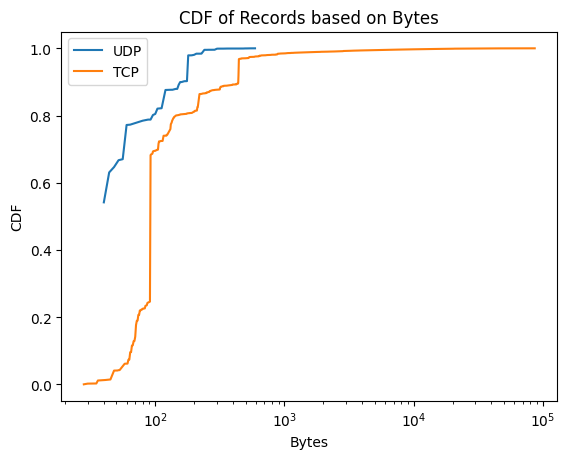

In [94]:
pdf = netflow_df.groupby("Protocol")['Bytes'].value_counts()

udp_cdf = pdf["UDP"].sort_index().cumsum() / pdf["UDP"].sort_index().sum()
tcp_cdf = pdf["TCP"].sort_index().cumsum() / pdf["TCP"].sort_index().sum()

plt.plot(tcp_cdf.index, tcp_cdf.values)
plt.plot(udp_cdf.index, udp_cdf.values)
plt.xlabel('Bytes')
plt.ylabel('CDF')
plt.title('CDF of Records based on Bytes')
plt.legend(["UDP", "TCP"])
plt.xscale('log')  # Set x-axis to log scale
plt.show()


# 1.1
My first observation is that nearly all packets are less than 1,000 bytes long. The second observation is that UDP packets tend to be smaller, and have no outliers larger than 1,000 bytes. More than half of the packets in each protocol have sizes of less than 100.

In [115]:
# Extract the first two octets of the source IP address


grouped_flows = netflow_df.groupby('src_ip_prefix')

# Group by the source IP prefix and count the number of flows
flows_per_src_prefix = grouped_flows['src_ip_prefix'].count()
most_common_ten_prefixes = flows_per_src_prefix.sort_values()[-10:]
print(f"Top 10 src prefixes:\n", most_common_ten_prefixes)

# Get the top ten IP address prefixes and their percentage of all flows
percentage_src_flows = (most_common_ten_prefixes.sum() / flows_per_src_prefix.sum()) * 100
print(f"Top 10 src account for {percentage_src_flows:.2f}%")


# Group by percentage of bytes sent
bytes_per_prefix = grouped_flows['Bytes'].sum()
biggest_ten_prefixes = bytes_per_prefix.sort_values()[-10:]
print(f"\nTop 10 src prefixes:\n", biggest_ten_prefixes)

percentage_of_traffic = (biggest_ten_prefixes.sum() / bytes_per_prefix.sum()) * 100
print(f"Top 10 src account for {percentage_of_traffic:.2f}%")

Top 10 src prefixes:
 src_ip_prefix
184.105     1775
64.125      1852
212.83      2042
141.212     2143
94.23       2205
169.45      2494
163.53      2981
222.186     5269
169.54      9424
116.211    17019
Name: src_ip_prefix, dtype: int64
Top 10 src account for 44.80%

Top 10 src prefixes:
 src_ip_prefix
163.53     120920
5.8        126940
222.186    211068
169.45     229448
42.120     326122
128.112    506604
140.205    510833
116.211    680922
169.54     867928
212.83     928311
Name: Bytes, dtype: int64
Top 10 src account for 37.41%


# 1.2 
The top 10 src prefixes (as counted by flow) are reported above. They account for 44.8% of all flows. The top 10 src prefixes (as counted by total bytes) are reborted above. These 10 flows account for 37.41% of total byte traffic.

In [116]:
# Analyze port number 0

count_by_src_port = netflow_df.groupby("Src port")["Src port"].count()
count_by_dest_port = netflow_df.groupby("Dst port")["Dst port"].count()

percent_with_src_23 = 100 * count_by_src_port[23] / count_by_src_port.sum()
percent_with_dest_23 = 100 * count_by_dest_port[23] / count_by_dest_port.sum()


print(f"Packets with src_port=23 account for {percent_with_src_23:.2f}% of flows")
print(f"Packets with dst_port=23 account for {percent_with_dest_23:.2f}% of flows")

Packets with src_port=23 account for 0.15% of flows
Packets with dst_port=23 account for 18.40% of flows


# 1.3
I chose port 23, which is used for Telnet. It appears as src_port in 0.15% of flows, but dst_port=23 for 18.4% of flows.

In [117]:
bytes_by_src = netflow_df.groupby('src_ip_prefix')["Bytes"].sum()
bytes_by_dst = netflow_df.groupby('dst_ip_prefix')["Bytes"].sum()

percent_bytes_from_router = 100 * bytes_by_src["128.112"] / bytes_by_src.sum()
print(f"Packets with src_ip=128.112.0.0/16 account for {percent_bytes_from_router:.2f}% of bytes")

percent_bytes_towards_router = 100 * bytes_by_dst["128.112"] / bytes_by_dst.sum()
print(f"Packets with dst_ip=128.112.0.0/16 account for {percent_bytes_towards_router:.2f}% of bytes")

incoming = netflow_df[netflow_df['dst_ip_prefix'] == "128.112"]
internal_flows = incoming[incoming['src_ip_prefix'] == "128.112"]

percent_bytes_within_router = 100 * (internal_flows["Bytes"].sum() / netflow_df["Bytes"].sum())
print(f"Packets with both src and dest within router account for {percent_bytes_within_router:.2f}% of bytes")

Packets with src_ip=128.112.0.0/16 account for 4.20% of bytes
Packets with dst_ip=128.112.0.0/16 account for 95.95% of bytes
Packets with both src and dest within router account for 0.84% of bytes


# 1.4
Packets with src_ip=128.112.0.0/16 account for 4.20% of bytes.
Packets with dst_ip=128.112.0.0/16 account for 95.95% of bytes.
Packets with both src and dest within router account for 0.84% of bytes.

Very little of the traffic is between hosts within the router's group. Traffic is largely in & out of the network. Interestingly, 95% of all bytes are headed into the router's network. More data coming in than leaving.

# 1.5
It does not change my answer to Q1.1. For Q1.2, I expect that the diversity of src IPs would increase. That is, the percentage of traffic accounted for by the top 10 src_ips would be less. For Q1.3, I would expect the telnet traffic in an internet Cafe to be smaller than a university. For Q1.4, I would expect the ratio of incoming/outgoing to be about the same.